## Overview

Plots and stats for the E Coli dataset, after removing outliers, before sequence clustering.

## Imports

In [48]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
)
from subpred.util import get_feature_score
from subpred.pssm import calculate_pssms_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Creating the dataset

In [49]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    outliers= ['P76773', 'Q47706', 'P02943', 'P75733', 'P69856', 'P64550'],
    verbose = True,
    tax_ids_filter = [83333],
    output_log = "../logs/ecoli_amino_sugar_dataset.log",
)

In [50]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,4.A,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,4.A,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,4.A,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P0AA47,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,plaP yeeF b2014 JW5330,Low-affinity putrescine importer PlaP,2.A.3.1.14,2.A,83333,MSHNVTPNTSRVELRKTLTLVPVVMMGLAYMQPMTLFDTFGIVSGL...
P08722,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,bglF bglC bglS b3722 JW3700,PTS system beta-glucoside-specific EIIBCA comp...,4.A.1.2.2,4.A,83333,MTELARKIVAGVGGADNIVSLMHCATRLRFKLKDESKAQAEVLKKT...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [51]:
df.keywords_transport.value_counts()


Amino-acid transport    51
Sugar transport         48
Name: keywords_transport, dtype: int64

In [52]:
df.keywords_location.value_counts()


Cell inner membrane;Cell membrane;Membrane;Transmembrane    98
Cell membrane;Membrane;Transmembrane                         1
Name: keywords_location, dtype: int64

In [53]:
df.keywords_transport_related.value_counts()


Transport                     79
Symport;Transport             15
Antiport;Transport             4
Antiport;Symport;Transport     1
Name: keywords_transport_related, dtype: int64

#### TCDB


In [54]:
df.tcdb_class.value_counts()


2.A    55
3.A    23
4.A    17
0.0     4
Name: tcdb_class, dtype: int64

## Feature generation

In [55]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

Hierarchical clustering can't quite distinguish all transporters into their categories, but there are two clusters with either slightly more amino acid transporters or slightly more sugar transporters (might not be significant):

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f2b4d1eeb50>)

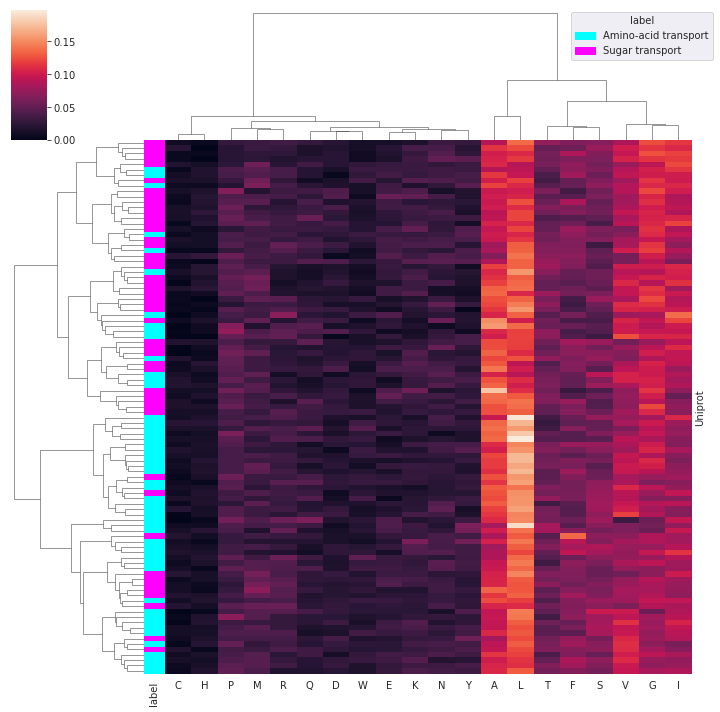

In [56]:
labeled_clustermap(df_aac, labels, xlabels="auto")

### PAAC plot

There are some low-level sub-clusters that contain one substrate almost exclusively.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f2b4d1e9190>)

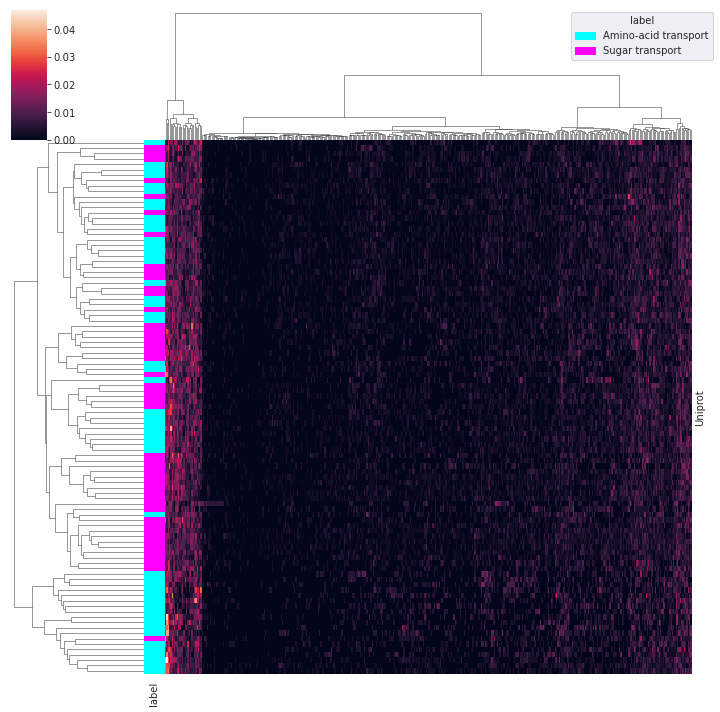

In [57]:
labeled_clustermap(df_paac, labels)

Again, there is a small cluster of transmembrane helix amino acids. However, the substrate specificity is often encoded in the remaining residues, so we will have to look at the feature importances first.

In [58]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
from collections import Counter

print(len(cluster1))
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] += 1
    counter[dipeptide[1]] += 1

counter


28


Counter({'A': 10, 'G': 10, 'I': 10, 'L': 14, 'V': 8, 'F': 1, 'S': 2, 'T': 1})

In [59]:
get_feature_score(df_paac, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).reset_index(drop=True).head(20)

,Feature,Normalized score,Measure
0,EE,0.024543,Feature importance (f_classif)
1,AG,0.021778,Feature importance (f_classif)
2,DK,0.020648,Feature importance (f_classif)
3,TG,0.019917,Feature importance (f_classif)
4,LY,0.019230,Feature importance (f_classif)
5,PW,0.016908,Feature importance (f_classif)
6,GD,0.016907,Feature importance (f_classif)
7,TN,0.016151,Feature importance (f_classif)
8,LV,0.015218,Feature importance (f_classif)
9,DF,0.012946,Feature importance (f_classif)


Two glutemic acids seem to be important. Other than GD, this looks different from the feature importances in A thaliana.

#### Antiport, Symport, Uniport

No distict clusters show up in the data, when annotating the clusters with transport mechanism.

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f2b5862edc0>)

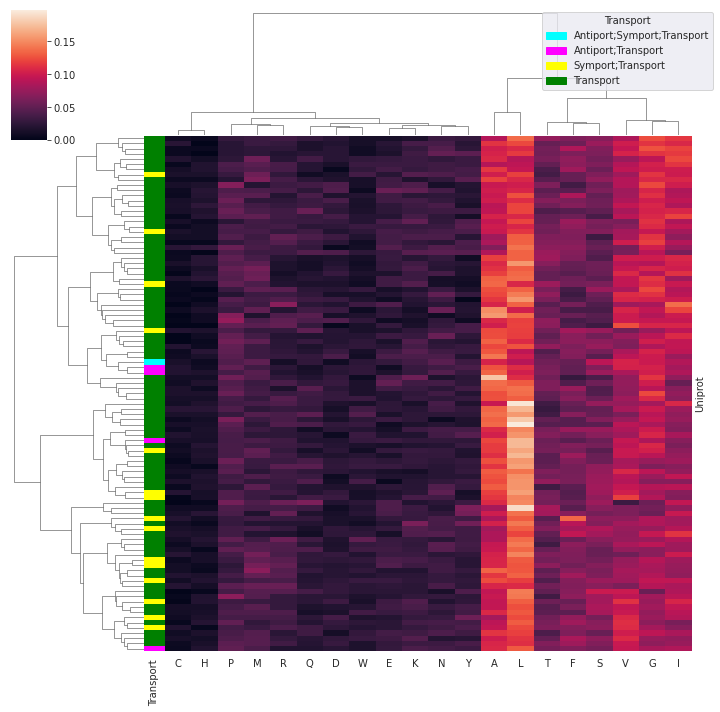

In [60]:
labeled_clustermap(
    df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto"
)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

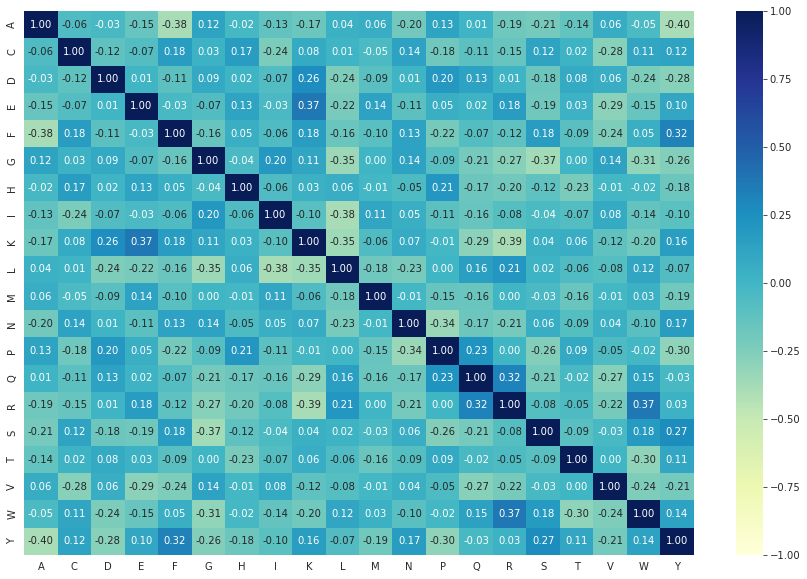

In [61]:
corr_heatmap(df_aac)

<AxesSubplot:>

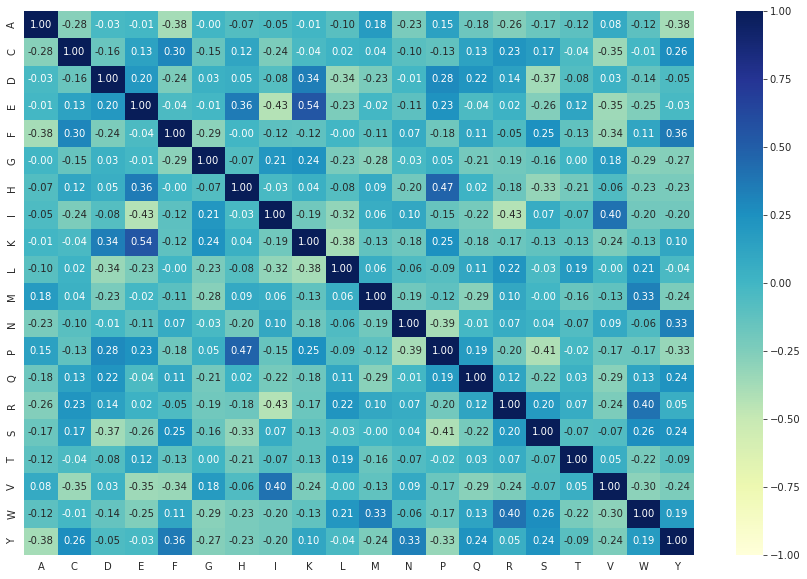

In [62]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

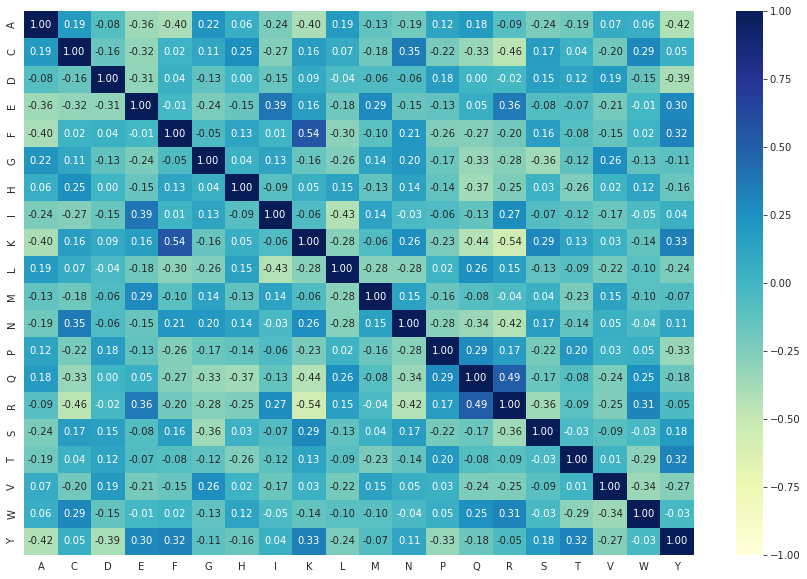

In [63]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

In [64]:
df_aac_long = (
    df_aac.stack(level=None)
    .reset_index()
    .rename(columns={"level_1": "Amino Acid", 0: "Frequency"})
    .merge(df.keywords_transport, left_on="Uniprot", right_index=True)
)
df_aac_long.head()

,Uniprot,Amino Acid,Frequency,keywords_transport
0,P69801,A,0.150376,Sugar transport
1,P69801,C,0.007519,Sugar transport
2,P69801,D,0.030075,Sugar transport
3,P69801,E,0.022556,Sugar transport
4,P69801,F,0.037594,Sugar transport


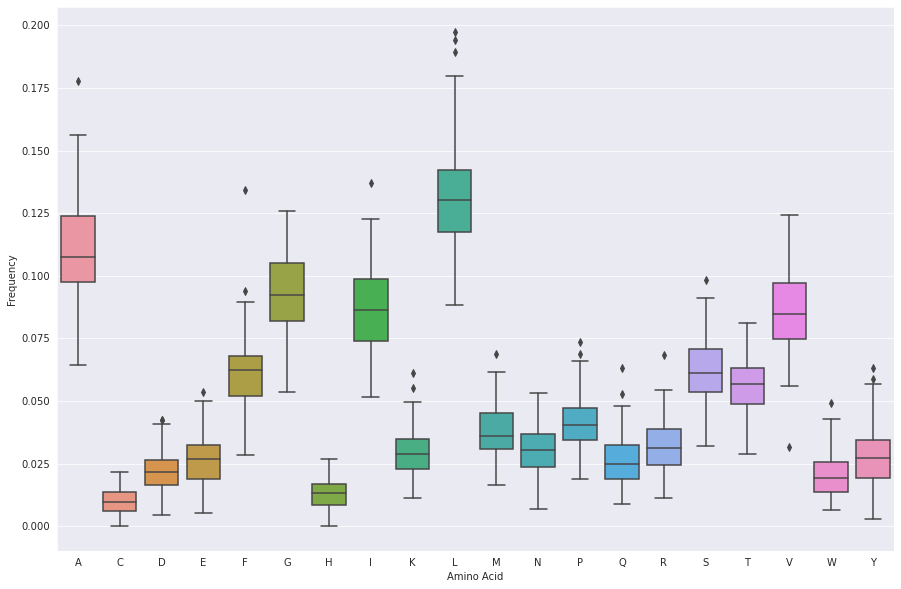

In [65]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    # hue="keywords_transport"
)

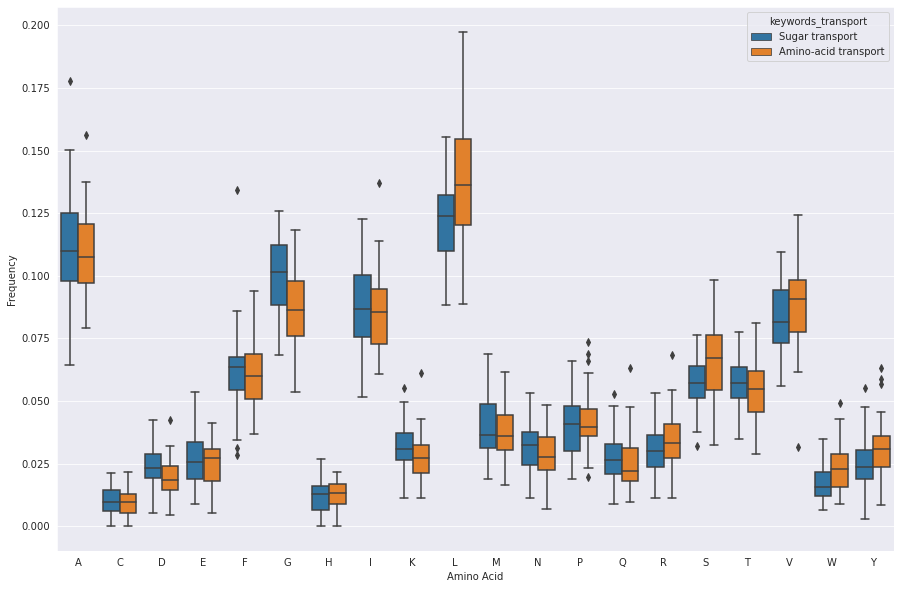

In [66]:

plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    hue="keywords_transport"
)

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

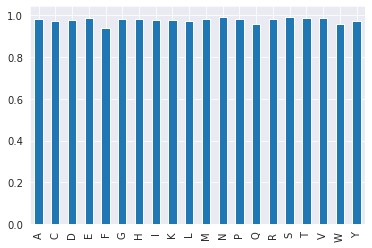

In [67]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

## Additional plots

### TCDB class

The non-2.A proteins mix well with the 2.A proteins, suggesting that they share a similar sequence composition

({'0.0': 'cyan', '2.A': 'magenta', '3.A': 'yellow', '4.A': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f2b4d83c550>)

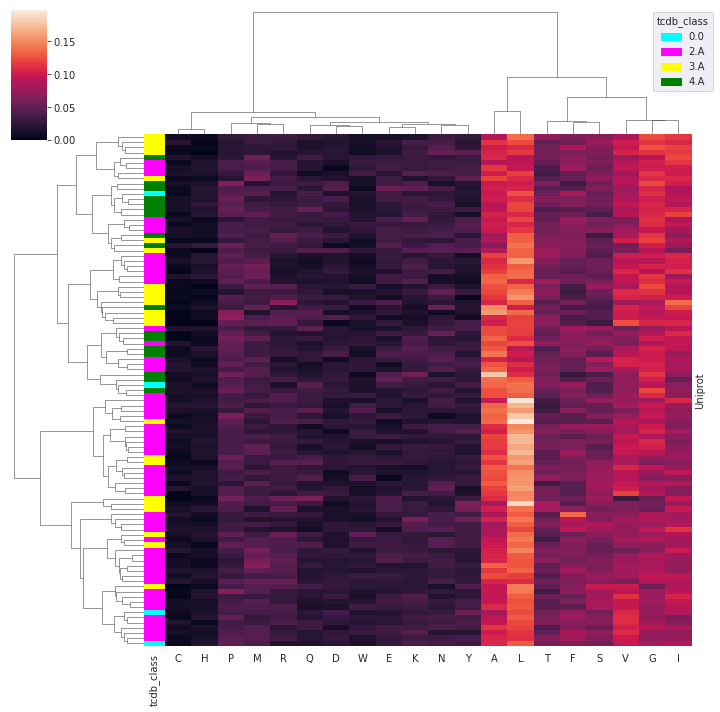

In [68]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")

## PCA plots

PCA plots for AAC and PAAC, the first two and three PC's.

### AAC

The data is not that clearly separable with just the AAC and the first two or thee PCs, but a pattern emerges.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

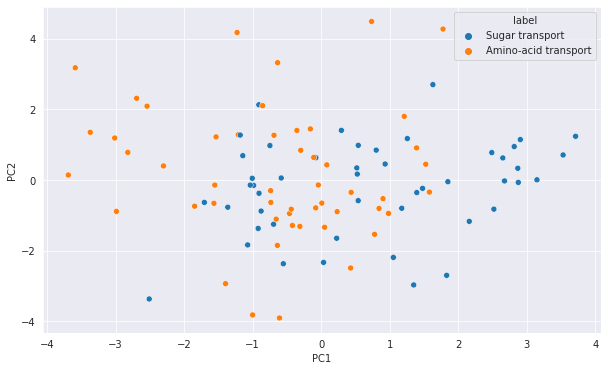

In [69]:
pca_plot_2d(df_aac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

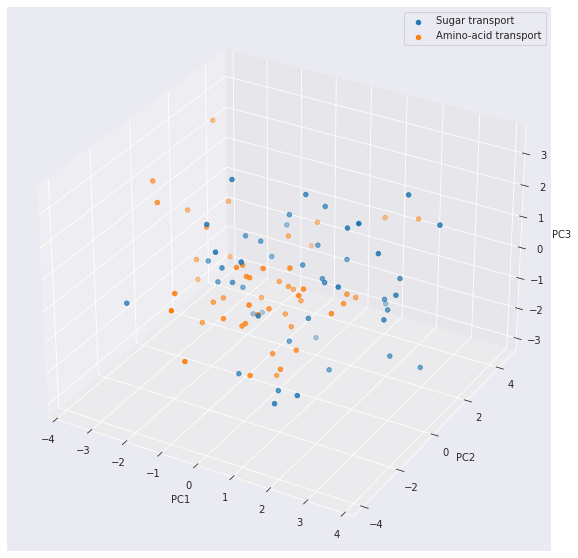

In [70]:
pca_plot_3d(df_aac, labels)

### PAAC

The protein P56579 still shows some distance to the rest of the dataset, but only for the PAAC feature.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

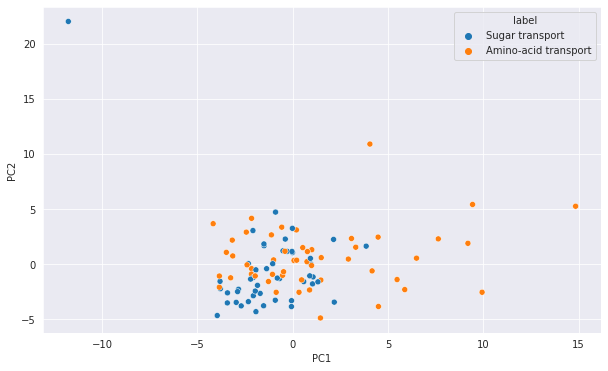

In [71]:
pca_plot_2d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

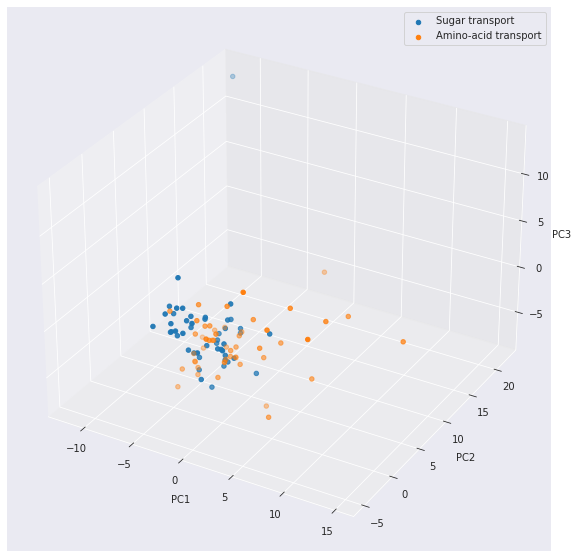

In [72]:
pca_plot_3d(df_paac, labels)

### PSSM

Interestingly, the protein P56579 is not an outlier in the PSSM dataset. Since most features will be derived from PSSM anyway (typically ~90% after feature selection), leaving the protein in should not make a huge difference.

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

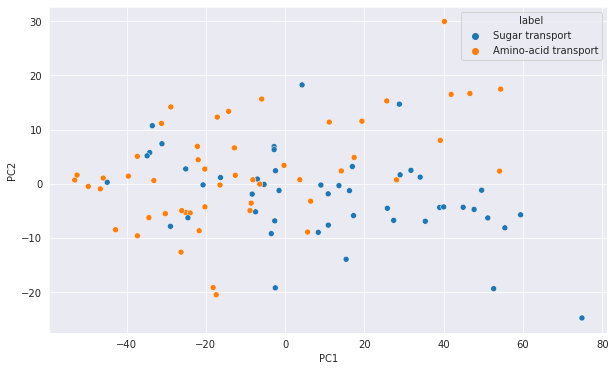

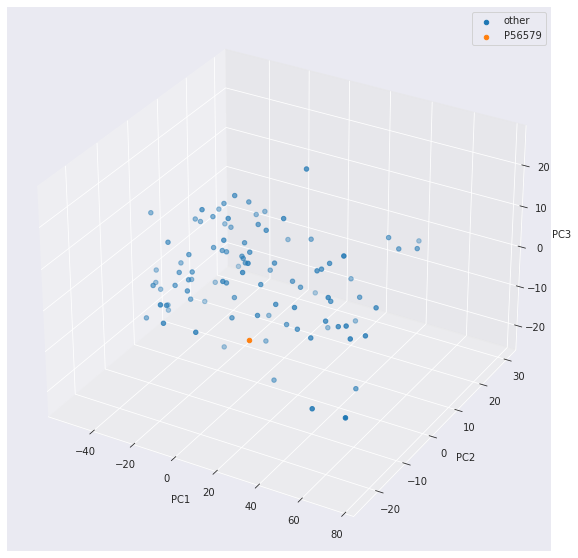

In [73]:
df_pssm = calculate_pssms_notebook(df.sequence)
pca_plot_2d(df_pssm, labels)
pca_plot_3d(df_pssm, pd.Series(["P56579" if x == "P56579" else "other" for x in df.index], index=df.index))

## F score Plot

In case of E. coli, the pattern that less frequent amino acids are predictive of substrate specificity does not hold true as much, with the exception of Tryptophane (W) and Asp (D).

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

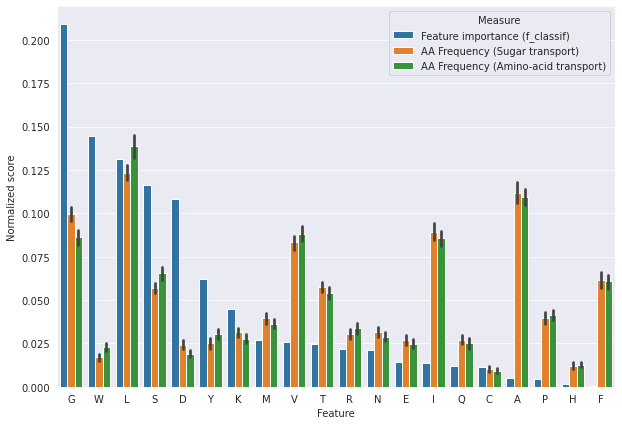

In [91]:
feature_importance_plot(df_aac, labels, method="f_classif")

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

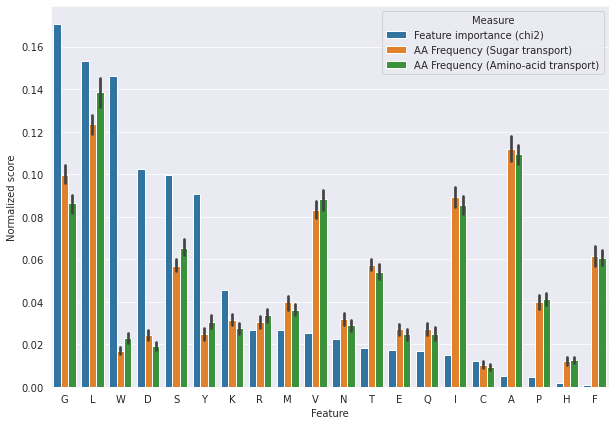

In [78]:
feature_importance_plot(df_aac, labels, method="chi2")